#  High-Energy Physics Data Analysis with Python Scikit-HEP 

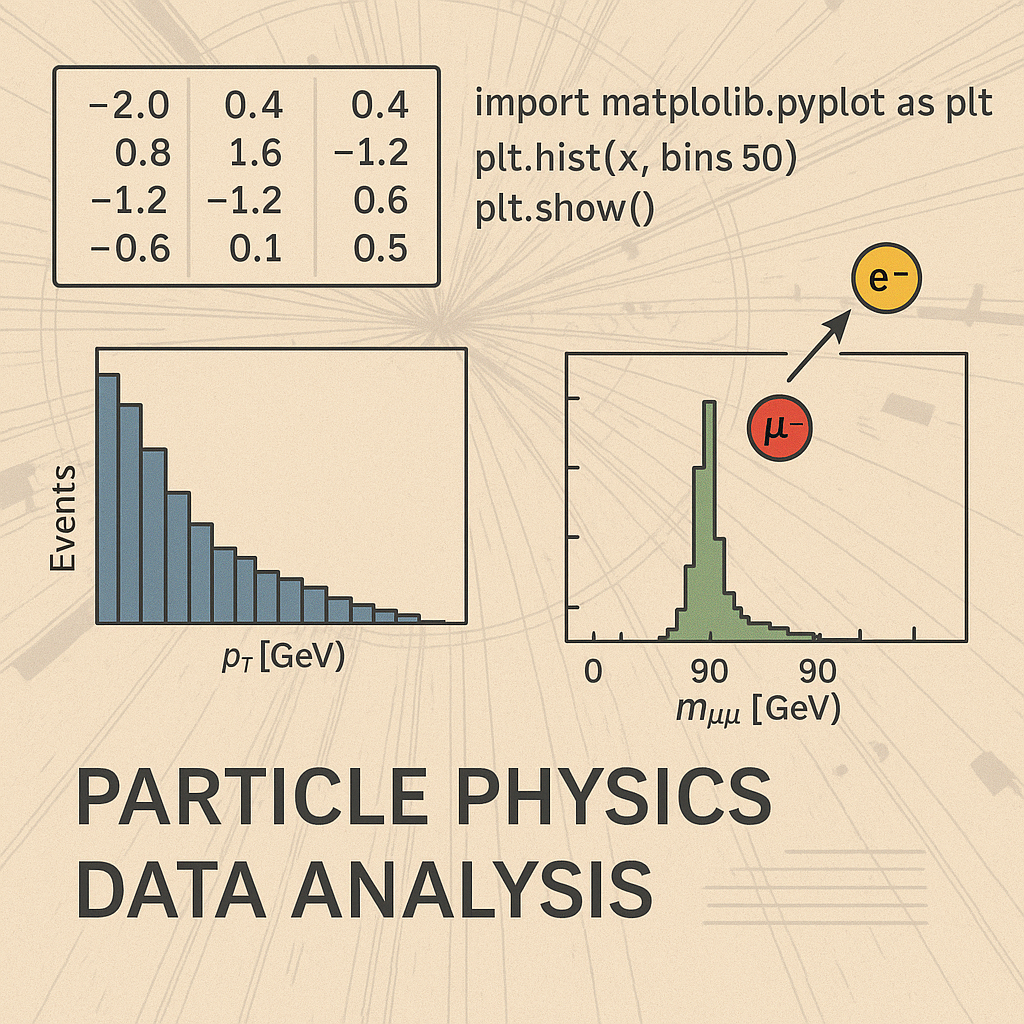

A major part of the analysis of collider physics data is processing and filtering this data to construct summary statistics upon which statistical analysis can then be conducted. Large particle physics experiments have enormous software infrastructures to deal with these tasks.

In this tutorial, we will use the `scikit-HEP` software stack to load the ubiquituous particle physics file format: ROOT; then apply selections to the loaded data; then construct histograms to visualise the data. All without using the ROOT software infrastructure itself.

Modern Pythonic HEP data analysis utilises columnar data structures in the form of arrays, and applies parallel operations on those arrays i.e. applying an operation to all events at once. This is in contrast to the traditional paradigm (exemplified in traditional ROOT macros) where so-called "event loops" iterate over events one-by-one. Array-based analysis is more align with modern data science and machine learning practices

There are several different Python packages useful for our analysis. If not already installed, you can pip-install e.g.

In [ ]:
!pip install uproot

## Downloading the data

We will examine an ATLAS OpenData dataset which contains the simulated reconstructed particles arising from the decay of a top-antitop quark pair in the ATLAS detector.

In [146]:
# This cell is only for downloading the ttbar dataset from CERNBox.
import urllib.request
urllib.request.urlretrieve("https://cernbox.cern.ch/s/nrBbuO7bu4wi82W/download", "ttbar_from_cernbox.root")


KeyboardInterrupt: 

## Reading the ROOT file

`uproot` is the package which controls the reading and writing of ROOT files. It doesn't always work brilliantly for writing ROOT files, so it's not perfect, but it works extremely well for reading them.

In [13]:
import uproot

The `uproot.open` syntax reads the file:

In [14]:
# file_tt  = uproot.open("ttbar_from_cernbox.root")
file_tt = uproot.open("~/Downloads/mc_345324.ggH125_WW2lep.2lep.root")

The `.keys()` method is used to inspect the file (as well as other objects like Trees)

In [15]:
file_tt.keys()

['mini;1']

Access the tree, named "mini" through the following, and the see what branches exist, again using `.keys()`

In [16]:
tree = file_tt["mini"]

In [17]:
tree.keys()

['runNumber',
 'eventNumber',
 'channelNumber',
 'mcWeight',
 'scaleFactor_PILEUP',
 'scaleFactor_ELE',
 'scaleFactor_MUON',
 'scaleFactor_PHOTON',
 'scaleFactor_TAU',
 'scaleFactor_BTAG',
 'scaleFactor_LepTRIGGER',
 'scaleFactor_PhotonTRIGGER',
 'trigE',
 'trigM',
 'trigP',
 'lep_n',
 'lep_truthMatched',
 'lep_trigMatched',
 'lep_pt',
 'lep_eta',
 'lep_phi',
 'lep_E',
 'lep_z0',
 'lep_charge',
 'lep_type',
 'lep_isTightID',
 'lep_ptcone30',
 'lep_etcone20',
 'lep_trackd0pvunbiased',
 'lep_tracksigd0pvunbiased',
 'met_et',
 'met_phi',
 'jet_n',
 'jet_pt',
 'jet_eta',
 'jet_phi',
 'jet_E',
 'jet_jvt',
 'jet_trueflav',
 'jet_truthMatched',
 'jet_MV2c10',
 'photon_n',
 'photon_truthMatched',
 'photon_trigMatched',
 'photon_pt',
 'photon_eta',
 'photon_phi',
 'photon_E',
 'photon_isTightID',
 'photon_ptcone30',
 'photon_etcone20',
 'photon_convType',
 'tau_n',
 'tau_pt',
 'tau_eta',
 'tau_phi',
 'tau_E',
 'tau_isTightID',
 'tau_truthMatched',
 'tau_trigMatched',
 'tau_nTracks',
 'tau_BDTid

We can load individual branches into separate awkward arrays:

In [18]:
jet_pt_array = tree["jet_pt"].array()
jet_pt_array.show(20) # The show method is a method for printing the array in a vertical readable format, where you specify N events

[[],
 [2.46e+04, 2.19e+04],
 [],
 [3e+04, 2.13e+04],
 [3.57e+04, 2.56e+04, 2.46e+04, 2.36e+04],
 [],
 [1.04e+05],
 [],
 [3.7e+04],
 [2.41e+04],
 ...,
 [5.42e+04, 2.3e+04, 2.23e+04],
 [],
 [],
 [],
 [],
 [9.88e+04, 2.14e+04],
 [2.67e+04],
 [],
 [6.9e+04, 3.6e+04, 3.32e+04, 2.45e+04, 2.08e+04, 2.05e+04, 2.02e+04]]


which we can see possesses a ragged array structure as there are a differing number of jets in each event.

## Awkward Operations on Arrays

We can use the `awkward` library to perform array operations on this array

In [19]:
import awkward as ak

For example, define an array called `jet_pt_array`, then count the number of jets in each event and write this to a new array

In [20]:
jet_pt_array = tree["jet_pt"].array()
Njets = ak.num(jet_pt_array) # This counts the number of jets in each event
Njets.show(20)

# This can also be achieved through
Njets = ak.count(jet_pt_array, axis=1) # where we have to specify the axis along which the count is made

[0,
 2,
 0,
 2,
 4,
 0,
 1,
 0,
 1,
 1,
 ...,
 3,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 7]


Basic arithmetic operations are valid:

In [21]:
# Coverting the jet_pt_array to GeV
jet_pt_array/1e3

<Array [[], ..., [69, 36, 33.2, ..., 20.5, 20.2]] type='628685 * var * float32'>

In [22]:
# Computing the maximum jet pT in each event a.k.a the pT of the leading/hardest jet
ak.max(jet_pt_array, axis=1)

<Array [None, 2.46e+04, None, ..., None, 6.9e+04] type='628685 * ?float32'>

## Masking

A key feature in much of data analysis, and especially in particle physics, is filtering the data. In particle physics we normally call this "applying selection cuts". In this array-based paradigm, we construct a mask (which is an array of booleans) and then apply this mask to the data. 

There are generally two type of selections we apply:
* Per-object - should individual objects pass the cut e.g. all jets greater than 25 GeV. The number of events remains the same after applying this filter, but the number of entries in each event changes.
* Per-event - does a whole entry in the array pass the selection e.g. has at least 4 jets? The number of events changes after applying this filter, but the individual surviving entries are unaltered. 

You should be careful when applying successive as the arrays change in shape and so the masks should also change accordingly.

In [23]:
# Per-object cut 
pt_greater_than_25_mask = jet_pt_array > 25e3
pt_greater_than_25_mask.show()

[[],
 [False, False],
 [],
 [True, False],
 [True, True, False, False],
 [],
 [True],
 [],
 [True],
 [False],
 ...,
 [True, False, False],
 [],
 [],
 [],
 [],
 [True, False],
 [True],
 [],
 [True, True, True, False, False, False, False]]


In [24]:
filtered_jet_pt_array = jet_pt_array[pt_greater_than_25_mask]
filtered_jet_pt_array.show()

[[],
 [],
 [],
 [3e+04],
 [3.57e+04, 2.56e+04],
 [],
 [1.04e+05],
 [],
 [3.7e+04],
 [],
 ...,
 [5.42e+04],
 [],
 [],
 [],
 [],
 [9.88e+04],
 [2.67e+04],
 [],
 [6.9e+04, 3.6e+04, 3.32e+04]]


Note that the number of entries in each row has now changed accordingly.

To emphasise the point that masks must also change, let's consider applying a selection for jet pT between 25 GeV and 100 GeV. If we naively apply these successively, we get an error:

In [25]:
pt_greater_25 = jet_pt_array > 25e3
pt_less_100 = jet_pt_array < 100e3

jet_pt_array[pt_greater_25][pt_less_100]

IndexError: cannot slice ListArray (of length 628685) with [[], [0, 1], [], [0, 1], [0, ...], ..., [0, 1], [0], [], [0, 1, 2, 3, 4, 5, 6]]: index out of range while attempting to get index 1 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-43/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

The above error is thrown because mask `pt_less_100` is being applied to the filtered object `jet_pt_array[pt_greater_25]`

We need to combine the masks and then apply to the array together...

In [157]:
# Combine masks using logical operations
jet_pt_array[pt_greater_25 & pt_less_100]

# This is also a valid syntax
jet_pt_array[pt_greater_25*pt_less_100]

<Array [[], [], ..., [6.9e+04, ..., 3.32e+04]] type='628685 * var * float32'>

Alternatively, we can define the second mask based on the resultant array from the first filter:

In [158]:
# Defining the first mask and applying to the original array
pt_geq_25_mask = jet_pt_array >= 25e3
jet_pt_array_geq_25 = jet_pt_array[pt_geq_25_mask]

# Defining the second mask from the filtered array and applying it as a subsequent filter
pt_leq_100_mask = jet_pt_array_geq_25 <= 100e3
jet_pt_array_geq_25[pt_leq_100_mask]

<Array [[], [], ..., [6.9e+04, ..., 3.32e+04]] type='628685 * var * float32'>

Similarly, we can apply per-event cuts on for example, the number of jets

In [26]:
Njets_mask = Njets >= 2
# Apply the mask to the original jet_pt_array
jet_pt_array[Njets_mask]

<Array [[2.46e+04, 2.19e+04], [...], ..., [...]] type='178119 * var * float32'>

Notice that the number of events (entries) in the array has changed.

In a proper particle physics analysis, we must apply per-object selections before we apply per-event selections

## Dealing with Multiple Branches

In reality, we want to apply any filter to any of the branches we are interested in. We could do this by loading all branches as separate arrays, but a nicer solution is to load all relevant branches into an array (though this can become memory-intensive). This is a rough analogue of directly using the `TTree` ROOT object.

In [27]:
jet_array = tree.arrays(["jet_pt", "jet_eta", "jet_phi", "jet_E", "jet_MV2c10"])

In [28]:
jet_array

<Array [{jet_pt: [], jet_eta: [], ...}, ...] type='628685 * {jet_pt: var * ...'>

Through the alias syntax, we can rename branches (note that you cannot use a hyphen in your alias)

In [29]:
# Dictionary of aliases
jet_branch_names = {
    "pt": "jet_pt",
    "eta": "jet_eta",
    "phi": "jet_phi",
    "E": "jet_E",
    "b_tag": "jet_MV2c10"
}

jet_array3 = tree.arrays(jet_branch_names.keys(),aliases=jet_branch_names)


One then extracts individual branches through a dict-like syntax:

In [30]:
jet_array3["eta"]

<Array [[], ..., [-1.98, 0.134, ..., -0.549]] type='628685 * var * float32'>

Here is an example of how one would apply the filters 25 GeV > jet_pt < 100 GeV and Njets >= 2

In [31]:
# First define and apply the pT mask
jet_pt_qegual_25_mask = jet_array3["pt"] >= 25e3
jet_pt_less_100_mask = jet_array3["pt"] <= 100e3
filtered_jet_array = jet_array3[jet_pt_qegual_25_mask & jet_pt_less_100_mask]

# Count the number of remaining jets (you could use any jet field for this: we will use pT)
Njets = ak.count(filtered_jet_array["pt"], axis=1)
# Although not necessary, you can add some new field to the filtered_jet_array provided the length matches
filtered_jet_array["Njets"] = Njets

# Finally, applying the Njets filter directly (combining the two lines into one)
filtered_jet_array_2 = filtered_jet_array[filtered_jet_array["Njets"]>=2]


## Operations with Four-Momenta 

We frequently wish to combine the four-momenta of final-state objects to study possible other particles which could have decayed into the presented final state. We can use the `vector` package to construct four-momenta objects, then access the attributes of the vectors or combine then as we wish.

In [32]:
# Let's take a look at the leptons in the system
lepton_array = tree.arrays(["lep_pt", "lep_eta", "lep_phi", "lep_E"])

In [33]:
# Import the vector module for handling 4-vectors
import vector 

# Create the four-vectors using the dictionary constructor
lepton_vectors = vector.zip({"pt": lepton_array["lep_pt"],
                            "eta": lepton_array["lep_eta"],
                            "phi": lepton_array["lep_phi"],
                            "E": lepton_array["lep_E"]})

The resultant `lepton_vectors` object has kinematic features which can be accessed through attributes, and an underlying awkward structure meaning that awkward operations can still be applied

In [34]:
# Display the transverse momentum (pT) of the leptons
print(lepton_vectors.pt)

# Count the number of leptons in each event
print(ak.num(lepton_vectors))

[[4.59e+04, 2.12e+04], [3.1e+04, 1.47e+04], ..., [...], [6.2e+04, 4.02e+04]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..., 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


Adding vectors gives us combined systems e.g.

In [35]:
combined_lepton_system = lepton_vectors[:,0] + lepton_vectors[:,1]  # Sum of the first two leptons in each event

# Display the invariant mass of the combined lepton system
print(combined_lepton_system.m)

[1.73e+04, 3.2e+04, 5.22e+04, 2.84e+04, ..., 6.34e+04, 4.91e+04, 2.46e+04]


Another important operation is boosting i.e. Lorentz transformations applied to four-momenta objects. In particular, boosting to the centre-of-mass frame (or zero-momentum frame) is achieved through:

In [36]:
l1_in_ZMF = lepton_vectors[:,0].boostCM_of(combined_lepton_system)  # Boost the first lepton to the center-of-mass frame of the combined lepton system
l2_in_ZMF = lepton_vectors[:,1].boostCM_of(combined_lepton_system)  # Boost the second lepton similarly

(l1_in_ZMF+l2_in_ZMF).show(20)  # Check the sum of the boosted leptons in the ZMF (should be close to zero)

[{x: -0.0234, y: -0.0195, z: 0.0625, t: 1.73e+04},
 {x: -0.00391, y: -0.000977, z: 0.00244, t: 3.2e+04},
 {x: -0.0186, y: 0.0137, z: 0.0215, t: 5.22e+04},
 {x: -0.043, y: 0, z: -0.312, t: 2.84e+04},
 {x: -0.00781, y: -0.00781, z: 0.00293, t: 5.77e+04},
 {x: 0.188, y: 0.141, z: 0.5, t: 1.07e+04},
 {x: -0.0273, y: -0.0391, z: -0.297, t: 6.91e+04},
 {x: -0.0117, y: 0.00195, z: 0.0156, t: 3.95e+04},
 {x: 0, y: 0.00781, z: 0.0312, t: 2.82e+04},
 {x: -0.00586, y: 0.00195, z: -0.000977, t: 5.38e+04},
 ...,
 {x: 0.0312, y: 0.0391, z: 0.0312, t: 3.5e+04},
 {x: 0, y: 0, z: 0, t: 6.36e+04},
 {x: 0.0166, y: 0.00977, z: 0.00195, t: 3.41e+04},
 {x: 0.00586, y: 0.00391, z: -0.00488, t: 6.55e+04},
 {x: 0.00293, y: -0.00781, z: 0.00195, t: 3.41e+04},
 {x: 0, y: -0.0547, z: -0.00781, t: 3.27e+04},
 {x: -0.00195, y: 0.000977, z: 0.0156, t: 6.34e+04},
 {x: -0.0166, y: -0.00586, z: -0.00781, t: 4.91e+04},
 {x: -0.0156, y: 0, z: 0, t: 2.46e+04}]


## Histogramming and plotting

Since high-energy physics in probabilistic in nature, histograms are an indispensible tool, in that they provide us with a tool for recording counts in different bins.

Note that matplotlib can provide fast plotting of histograms straight from arrays of data (though may first require some manipulation of those arrays)

(array([ 9329., 12676., 12671., 11182., 10267.,  9651.,  8587.,  7669.,
         6558.,  5758.]),
 array([25014.34765625, 32512.79882812, 40011.25      , 47509.69921875,
        55008.1484375 , 62506.6015625 , 70005.046875  , 77503.5       ,
        85001.953125  , 92500.3984375 , 99998.8515625 ]),
 [<matplotlib.patches.Polygon at 0x12f2d9410>])

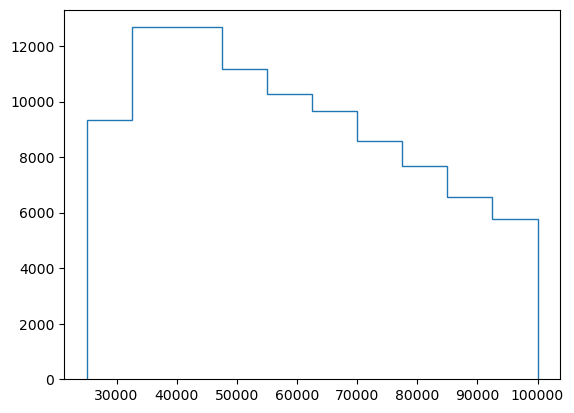

In [37]:
# Plotting the leading jet pT using matplotlib 
import matplotlib.pyplot as plt
leading_jet_pt = filtered_jet_array_2["pt"][:, 0]  # Get the leading jet pT (first jet in each event)
plt.hist(leading_jet_pt, histtype='step') # Plot the histogram

But we will really require a more powerful framework which can construct histogram objects. The preference is now is `Hist`, where one constructs an empty histogram with designated binning in advance, then fills this histogram with specified data. 

In [133]:
from hist import Hist, axis
jet_pt_hist = Hist(axis.Regular(bins=10, start=0, stop=1e5, name="x"))
jet_pt_hist.fill(leading_jet_pt)

Hist(Regular(10, 0, 100000, name='x'), storage=Double()) # Sum: 1982071.0

There also then exists a dedicated plotting module for high energy physical histograms: `mplhep`

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x157b9aa10>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

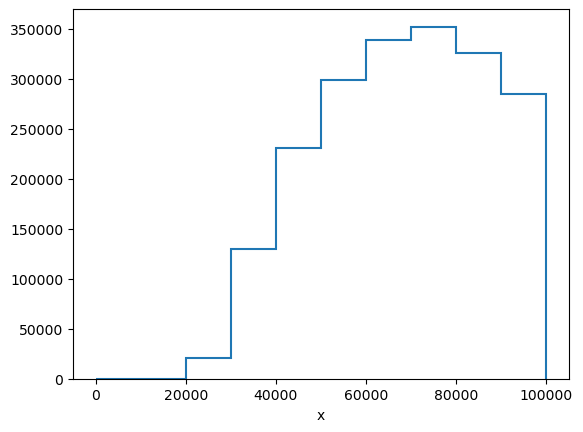

In [134]:
import mplhep as hep 

hep.histplot(jet_pt_hist)

In [1]:
jet_array

NameError: name 'jet_array' is not defined

## Writing data to files

### Saving to ROOT

Saving arrays as a TTree using uproot is possible, but only if they are singly-nested i.e. a ragged array of floats, not a ragged array of arrays. To do this, we construct a dictionary where each key is the branch name and each value is the branch:


In [41]:
# Turn an array of multiple fields into a dictionary using dict comprehension
jet_array_dict = {k:jet_array3[k] for k in jet_array3.fields} # The .fields attribute gives us the branches of the array 

# Save to file with tree named
with uproot.recreate("filtered_jet_array_170625.root") as f_out:
    f_out["tree"] = jet_array_dict  



Note that this does save each branch with an extra branch whose name is the branch name prepended by the letter "n". I'm not sure how - or if - one can get around this

### Saving to HDF5

HDF5 (.h5) is perhaps the most common file format for machine learning practices. Unfortunately it can't save ragged formats so we need to first turn our data structures into rectangular numpy arrays. This involves first creating a padded awkward array.

In [69]:
size_to_pad_to = 5  # Define the size to pad to
padded_pt_array = ak.pad_none(jet_array3["pt"], size_to_pad_to, clip=True)  # Pad the jet pT array to a fixed length of 10 jets per event

# If we want, we can replace the None elements with some other number e.g. -99
padded_pt_array = ak.fill_none(padded_pt_array, -99)  # Fill None values with -99

Then convert to a numpy array:

In [75]:
padded_pt_numpy_array = padded_pt_array.to_numpy()

Repeating for the other jet observables

In [76]:
# Repeat for eta, phi, e 
padded_eta_array = ak.pad_none(jet_array3["eta"], size_to_pad_to, clip=True)
padded_eta_array = ak.fill_none(padded_eta_array, -99)  # Fill None values with -99
padded_eta_numpy_array = padded_eta_array.to_numpy()
padded_phi_array = ak.pad_none(jet_array3["phi"], size_to_pad_to, clip=True)
padded_phi_array = ak.fill_none(padded_phi_array, -99)  # Fill None values with -99
padded_phi_numpy_array = padded_phi_array.to_numpy()
padded_E_array = ak.pad_none(jet_array3["E"], size_to_pad_to, clip=True)
padded_E_array = ak.fill_none(padded_E_array, -99)  # Fill None values with -99
padded_E_numpy_array = padded_E_array.to_numpy()

Joininng the arrays together into a combined structure which is of shape Nevents x Njets (padded to 5) x Nfeatures

In [78]:
import numpy as np
padded_jet_array = np.stack((padded_pt_numpy_array, padded_eta_numpy_array, padded_phi_numpy_array, padded_E_numpy_array), axis=-1)



We can embue numpy arrays with more structure by specifying a data-type

In [83]:
# Creating the data type (the fields)
jet_dtype = np.dtype([("pt"       , np.float64),
                       ("eta"     , np.float64),
                       ("phi"     , np.float64),
                       ("energy"  , np.float64)])

# Initialising a numpy array of zeros with specified shape and data type
jet_data = np.zeros((len(jet_array3),size_to_pad_to), dtype=jet_dtype)

# Filling the numpy array with the padded values
jet_data["pt"] = padded_pt_numpy_array
jet_data["eta"] = padded_eta_numpy_array
jet_data["phi"] = padded_phi_numpy_array
jet_data["energy"] = padded_E_numpy_array

Finally, one creates a dataset within the HDF5 file scope and saves the file

In [85]:
import h5py 
with h5py.File("jet_data_example.h5", 'w') as f_out:
    f_out.create_dataset("jets", data=jet_data, )  # Save the jet data with gzip compression
